# CL for multi-annotator data [cifar10h] [benchmarking]
- This notebook uses the results from the model_train_pred notebook to evaluate model performance. Also evaluates general multi-annotator dataset health

In [9]:
from cleanlab.multiannotator import get_label_quality_multiannotator, get_multiannotator_stats

In [10]:
%load_ext autoreload
%autoreload 2

import cleanlab
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy
from cleanlab.filter import find_label_issues
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, accuracy_score, log_loss
from matplotlib import pyplot as plt
from IPython.display import Image, display
import os

sys.path.insert(0, "../")
from utils.eval_metrics import lift_at_k
from utils.active_learning_scores import least_confidence
# experimental version of label quality ensemble scores with additional weighting schemes
from utils.label_quality_ensemble_scores_experimental import get_label_quality_ensemble_scores_experimental

path = os.getcwd()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
!pwd

/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks


### Load/Analyze Cifar10h Data

In [12]:
# If this line throws an error, make sure you correctly downloaded and unzipped cifar10h-raw data

pred_probs_multiannotator = np.load('./data/cifar10h/cifar10h-probs.npy')
df = pd.read_csv('./data/cifar10h/cifar10h-raw.csv')
df = df[df.cifar10_test_test_idx != -99999] # dropping all attention check trials
df.head()

,annotator_id,trial_index,is_attn_check,true_category,chosen_category,true_label,chosen_label,correct_guess,cifar10_test_test_idx,image_filename,subcategory,reaction_time,time_elapsed
0,0,0,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1342,1342
1,0,1,0,deer,horse,4,7,0,1118,alces_alces_s_000236.png,alces_alces,4305,6244
2,0,2,0,horse,horse,7,7,1,5965,stud_mare_s_001236.png,stud_mare,2811,9274
3,0,3,0,truck,automobile,9,1,0,6167,delivery_van_s_000100.png,delivery_van,1136,10610
4,0,4,0,deer,bird,4,2,0,373,elk_s_000359.png,elk,4410,15994


In [13]:
df.describe()

,annotator_id,trial_index,is_attn_check,true_label,chosen_label,correct_guess,cifar10_test_test_idx,reaction_time,time_elapsed
count,514200.000000,514200.000000,514200.0,514200.000000,514200.000000,514200.000000,514200.000000,5.142000e+05,5.142000e+05
mean,1285.000000,104.000000,0.0,4.500000,4.525208,0.948744,5000.431614,1.935603e+03,2.931535e+05
std,742.184437,60.592963,0.0,2.872284,2.870586,0.220520,2886.618758,1.162328e+04,2.222935e+05
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-6.277500e+04,4.810000e+02
25%,642.000000,51.750000,0.0,2.000000,2.000000,1.000000,2502.000000,1.206000e+03,1.371220e+05
50%,1285.000000,104.000000,0.0,4.500000,5.000000,1.000000,5000.000000,1.483000e+03,2.709670e+05
75%,1928.000000,156.250000,0.0,7.000000,7.000000,1.000000,7500.000000,1.969000e+03,4.106732e+05
max,2570.000000,208.000000,0.0,9.000000,9.000000,1.000000,9999.000000,7.686536e+06,9.029878e+06


#### restructure dataset information
- num_datapoints (N), num_annotators (M)
- hlabels: (N,M)
- hlabels_error_mask: (N,M) where True=error
- hannotator_mask: (N,M) where True=annotator x anotated that
- htrue_labels: (K=10,000,) # indexed same way as cifar10
- htrue_images: (K=10,000,)

In [14]:
# get annotations per annotator in numpy array (rows = annotations, cols = annotators)

num_datapoints = df['cifar10_test_test_idx'].max() + 1
num_annotators = df['annotator_id'].max() + 1

hlabels = np.full((num_datapoints, num_annotators), np.nan) # all annotator labels np.full([height, width, 9], np.nan)
hlabels_error_mask = np.zeros((num_datapoints, num_annotators), dtype=bool) # mask of annotator errors
hannotator_mask = np.zeros((num_datapoints, num_annotators), dtype=bool) # mask of what each person annotated

print(hlabels.shape, hlabels.sum(), hlabels_error_mask.shape, hlabels_error_mask.sum(), hannotator_mask.shape, hannotator_mask.sum())

for annotator_id in range(num_annotators):
    adf = df[df.annotator_id == annotator_id] # 200 annotations per annotator
    annotations_idx = adf['cifar10_test_test_idx'].values
    annotations = adf['chosen_label'].values
    errors = adf['correct_guess'].values
    
    hlabels[annotations_idx, annotator_id] = annotations
    hlabels_error_mask[annotations_idx, annotator_id] = errors
    hannotator_mask[annotations_idx, annotator_id] = True

print(hlabels.shape, hlabels.sum(), hlabels_error_mask.shape, hlabels_error_mask.sum(), hannotator_mask.shape, hannotator_mask.sum())

(10000, 2571) nan (10000, 2571) 0 (10000, 2571) 0
(10000, 2571) nan (10000, 2571) 487844 (10000, 2571) 514200


In [15]:
# get true labels as numpy array (rows = true labels,) and true images

htrue_labels = np.zeros((num_datapoints, ))
htrue_images = np.empty((num_datapoints, ) ,dtype=object)

idx_to_label = \
[(idx,label,image) for idx,label,image in zip(df['cifar10_test_test_idx'],df['true_label'],df['image_filename'])]
idx_to_label = list(set(idx_to_label))

idx = [idx_to_label[0] for idx_to_label in idx_to_label]
true_label = [idx_to_label[1] for idx_to_label in idx_to_label]
htrue_image = [idx_to_label[2] for idx_to_label in idx_to_label]

htrue_labels[idx] = true_label
htrue_images[idx] = htrue_image

#### get accuracy of individual annotators

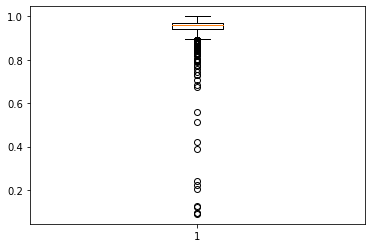

,score
count,2571.000000
mean,0.948744
std,0.057286
min,0.090000
25%,0.940000
50%,0.960000
75%,0.970000
max,1.000000


In [16]:
# Get accuracy of individual annotators
def plt_annotator_accuracy(labels_error_mask, annotator_mask):
    annotator_accuracy = labels_error_mask.sum(axis=0) / annotator_mask.sum(axis=0)
    plt.boxplot(annotator_accuracy)
    plt.show()

    df_describe = pd.DataFrame(annotator_accuracy, columns=['score'])
    return df_describe

df_describe = plt_annotator_accuracy(hlabels_error_mask, hannotator_mask)
df_describe.describe()

#### get accuracy of consensus labels

In [17]:
# Compute the consensus_labels
# TODO: conditional based on consensus_method, consensus_method can be a List[str], add dawid-skene
def get_consensus_labels(labels_multiannotator, pred_probs):
    mode_labels_multiannotator = labels_multiannotator.mode(axis=1)
    consensus_labels = []
    for i in range(len(mode_labels_multiannotator)):
        consensus_labels.append( int(mode_labels_multiannotator.iloc[i][pred_probs[i][mode_labels_multiannotator.iloc[i].dropna().astype(int).to_numpy()
                    ].argmax()
                ]
            )
        )
    return np.array(consensus_labels)

def get_consensus_accuracy_report(labels, true_labels, annotator_mask, pred_probs_multiannotator):
    labels_multiannotator = pd.DataFrame(labels)
    consensus_labels = get_consensus_labels(labels_multiannotator, pred_probs_multiannotator)
    correct_consensus = (true_labels == consensus_labels) + 0
    all_consensus = [1] * len(true_labels)
    correct_consensus.sum() / len(correct_consensus)

    num_annotators_per_example = annotator_mask.sum(axis=1)

    consensus_accuracy = pd.DataFrame(zip(correct_consensus, num_annotators_per_example,all_consensus), columns=['consense','num_a','total_seen'])
    consensus_accuracy = consensus_accuracy.groupby('num_a')[["consense", "total_seen"]].sum().reset_index()
    consensus_accuracy['consensus_acc'] = consensus_accuracy['consense'] / consensus_accuracy['total_seen']
    return consensus_accuracy

# per example, number of annotators that agree with consensus label (% agreement = x with lower confidence bound = confidence interval for true proportion of annotators that greed (jonas share))
# plot accuracy of consensus label given number of annotators that agree
# if acc to num annotators and num annotator agreement % then we perform best

def plot_labels_multiannotator(labels, true_labels, pred_probs_multiannotator=None):
    labels_multiannotator = pd.DataFrame(labels)
    
    if pred_probs_multiannotator is None:
        pred_counts = labels.sum(axis=1)
        pred_probs_multiannotator = labels / pred_counts[:,np.newaxis]

    consensus_labels = get_consensus_labels(labels_multiannotator, pred_probs_multiannotator)
    consensus_labels_tile = np.repeat(consensus_labels[:,np.newaxis], labels_multiannotator.shape[1], axis=1)
    num_annotators_per_ex = np.count_nonzero(~np.isnan(labels), axis=1)
    annotator_agreement = (labels_multiannotator == consensus_labels_tile) # Number of annotators matches consensus
    annotator_agreement = annotator_agreement.sum(axis=1)
    bin_consensus = (true_labels == consensus_labels) + 0
    consensus_accuracy = pd.DataFrame(zip(annotator_agreement,bin_consensus), columns=['annotator_agreement','bin_consense'])
    _ = consensus_accuracy.boxplot(by=['bin_consense'], figsize=(7,7))
    consensus_accuracy = consensus_accuracy.groupby('bin_consense')[['annotator_agreement']].sum().reset_index()

    return consensus_accuracy    

,bin_consense,annotator_agreement
0,0,2326
1,1,486587


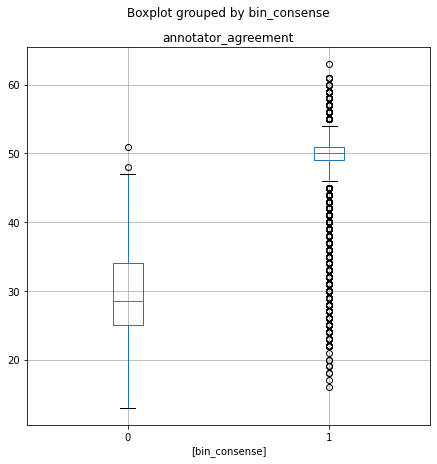

In [18]:
plot_labels_multiannotator(hlabels, htrue_labels)

In [19]:
consensus_accuracy = get_consensus_accuracy_report(hlabels, 
                              htrue_labels, 
                              hannotator_mask, 
                              pred_probs_multiannotator)
consensus_accuracy

,num_a,consense,total_seen,consensus_acc
0,50,2798,2816,0.993608
1,51,3332,3362,0.991077
2,52,2161,2181,0.990830
3,53,979,986,0.992901
4,54,339,341,0.994135
5,55,93,95,0.978947
6,56,36,36,1.000000
7,57,80,80,1.000000
8,58,49,49,1.000000
9,59,38,38,1.000000


<AxesSubplot:xlabel='num_a'>

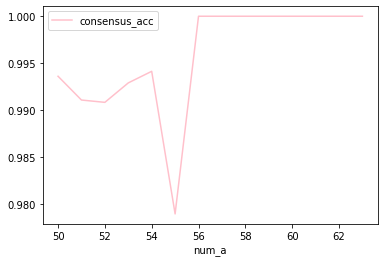

In [20]:
consensus_accuracy[['num_a','consensus_acc']].plot(kind='line',x='num_a',y='consensus_acc',color='pink')

In [21]:
# make prec/recall plot for conensus_labels correct/not correct for each example given preds from model are now our scores
# high level: when few annotators. unreliable

### Try random dropout of random number of examples
- randomly flip some 1 bits in annotator mask per row
- apply annotator mask to labels (nan where it is 0) and
- labels_error_mask (false where it is 0)
- calculate new pred_probs multiannotator

In [22]:
# labels- all annotator labels np.full([height, width, 9], np.nan)
# labels_error_mask- mask of annotator errors
# annotator_mask- mask of what each person annotated

def get_sample_labels(x_sample, y_sample, labels, labels_error_mask, annotator_mask):
    s_annotator_mask = annotator_mask.copy()
    s_annotator_mask[(x_sample,y_sample)] = 0
    s_labels_error_mask = s_annotator_mask & labels_error_mask
    s_labels = labels.copy()
    np.copyto(s_labels, np.nan, where=s_annotator_mask)
    print('Total idxs dropped: ', annotator_mask.sum() - s_annotator_mask.sum())
    return s_labels, s_labels_error_mask, s_annotator_mask

**randomly drop x percent of all labels**

In [23]:
# randomly drop x percent of all labels
percent_dropped = 0.4

x,y = np.where(hannotator_mask == 1)
drop_idx = np.random.choice(np.arange(len(x)), int(len(x)*percent_dropped), replace=False)
x_sample = x[drop_idx]
y_sample = y[drop_idx]
s_labels, s_labels_error_mask, s_annotator_mask = get_sample_labels(x_sample, y_sample, hlabels, hlabels_error_mask, hannotator_mask)

Total idxs dropped:  205680


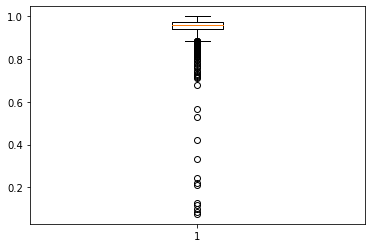

,score
count,2571.000000
mean,0.948861
std,0.058945
min,0.075630
25%,0.938462
50%,0.957983
75%,0.974359
max,1.000000


In [24]:
df_describe = plt_annotator_accuracy(s_labels_error_mask, s_annotator_mask)
df_describe.describe()

In [25]:
consensus_accuracy = get_consensus_accuracy_report(s_labels, 
                              htrue_labels, 
                              s_annotator_mask, 
                              pred_probs_multiannotator)
consensus_accuracy

,num_a,consense,total_seen,consensus_acc
0,18,4,4,1.000000
1,19,4,4,1.000000
2,20,8,8,1.000000
3,21,34,34,1.000000
4,22,59,60,0.983333
5,23,103,103,1.000000
6,24,170,170,1.000000
7,25,322,323,0.996904
8,26,452,455,0.993407
9,27,605,612,0.988562


<AxesSubplot:xlabel='num_a'>

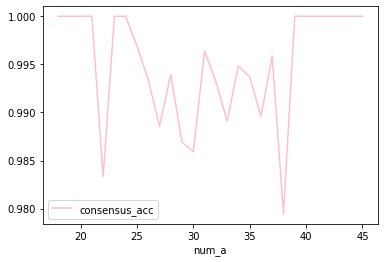

In [26]:
consensus_accuracy[['num_a','consensus_acc']].plot(kind='line',x='num_a',y='consensus_acc',color='pink')
# x axis can be lower bound on consensus labels (i.e. how many annotators agreed)

,bin_consense,annotator_agreement
0,0,978
1,1,194590


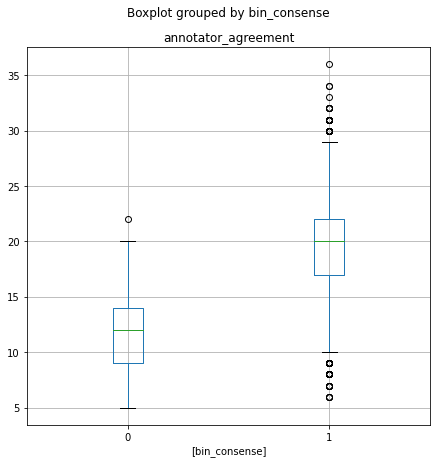

In [27]:
plot_labels_multiannotator(s_labels, htrue_labels)

**Drop x rows per every annotator**

In [28]:
percent_dropped = 0.4
rows_dropped = int(200 * percent_dropped)
print('rows dropped: ', rows_dropped)

x,y = np.where(hannotator_mask == 1)
df_delete = pd.DataFrame(zip(x,y),columns=['x','y'])
df_keep = df_delete.drop(df_delete.groupby('y').sample(n=200 - rows_dropped).index)
x_sample,y_sample = df_keep['x'].values, df_keep['y'].values
s_labels, s_labels_error_mask, s_annotator_mask = get_sample_labels(x_sample, y_sample, hlabels, hlabels_error_mask, hannotator_mask)

rows dropped:  80
Total idxs dropped:  205680


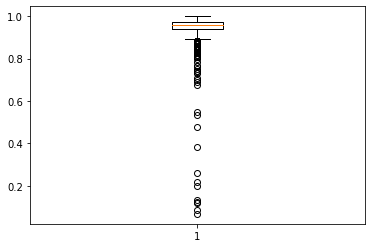

,score
count,2571.000000
mean,0.948772
std,0.058322
min,0.066667
25%,0.941667
50%,0.958333
75%,0.975000
max,1.000000


In [29]:
df_describe = plt_annotator_accuracy(s_labels_error_mask, s_annotator_mask)
df_describe.describe()

In [30]:
consensus_accuracy = get_consensus_accuracy_report(s_labels, 
                              htrue_labels, 
                              s_annotator_mask, 
                              pred_probs_multiannotator)
consensus_accuracy

,num_a,consense,total_seen,consensus_acc
0,16,1,1,1.000000
1,18,1,1,1.000000
2,19,3,3,1.000000
3,20,11,11,1.000000
4,21,30,30,1.000000
5,22,50,51,0.980392
6,23,115,116,0.991379
7,24,166,168,0.988095
8,25,305,308,0.990260
9,26,460,464,0.991379


<AxesSubplot:xlabel='num_a'>

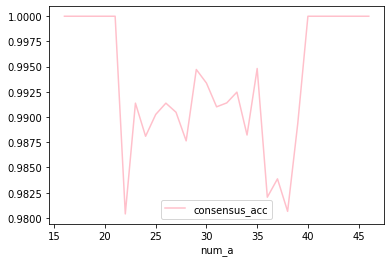

In [31]:
consensus_accuracy[['num_a','consensus_acc']].plot(kind='line',x='num_a',y='consensus_acc',color='pink')

,bin_consense,annotator_agreement
0,0,1128
1,1,194576


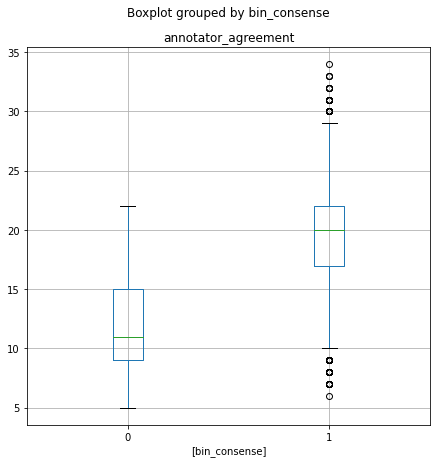

In [32]:
plot_labels_multiannotator(s_labels, htrue_labels)

**Drop x values for every row**

In [33]:
# rows have min 50 values
percent_dropped = 0.4
vals_dropped = int(50 * percent_dropped)
print('vals dropped: ', vals_dropped)

x,y = np.where(hannotator_mask == 1)
df_delete = pd.DataFrame(zip(x,y),columns=['x','y'])
df_keep = df_delete.drop(df_delete.groupby('x').sample(n=50 - vals_dropped).index)
x_sample,y_sample = df_keep['x'].values, df_keep['y'].values
s_labels, s_labels_error_mask, s_annotator_mask = get_sample_labels(x_sample, y_sample, hlabels, hlabels_error_mask, hannotator_mask)

vals dropped:  20
Total idxs dropped:  214200


In [34]:
consensus_accuracy = get_consensus_accuracy_report(s_labels, 
                              htrue_labels, 
                              s_annotator_mask, 
                              pred_probs_multiannotator)
consensus_accuracy

,num_a,consense,total_seen,consensus_acc
0,30,9918,10000,0.9918


,bin_consense,annotator_agreement
0,0,1096
1,1,202587


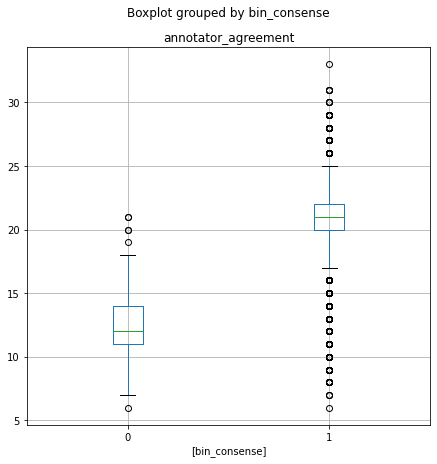

In [35]:
plot_labels_multiannotator(s_labels, htrue_labels)

### Load models and data

In [36]:
# dictionaries to map to display name
method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
    "entropy-False": "Entropy",
    "least_confidence-False": "Least Confidence",
}

model_display_name_dict = {"resnet18": "ResNet-18",}

models = ["resnet18"] # can also be: "resnet50d", "efficientnet_b1", "twins_pcpvt_base", "swin_base_patch4_window7_224"

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

In [37]:
# read numpy files from model_train_pred
numpy_out_folder = './data/model_data_070622/'
pred_probs = np.load(numpy_out_folder + "test_pred_probs.npy")
pred_labels = np.load(numpy_out_folder + "test_preds.npy")
true_labels = np.load(numpy_out_folder + "test_labels.npy")
images = np.load(numpy_out_folder + "test_images.npy", allow_pickle=True)
idxs = [int(image.split('/')[-1][-8:-4]) for image in images]

# boolean mask of label errors
labels = pred_labels # labels can change to annotator labels!!
label_errors_target = labels != true_labels

# set all cifar10h annotator data to the correct indexing
htrue_labels = htrue_labels[idxs]
htrue_images = htrue_images[idxs]
hlabels = hlabels[idxs]
hlabels_error_mask = hlabels_error_mask[idxs]
hannotator_mask = hannotator_mask[idxs]

assert np.array_equal(htrue_labels, true_labels) # check cifar10h sort matches what our model predicted on

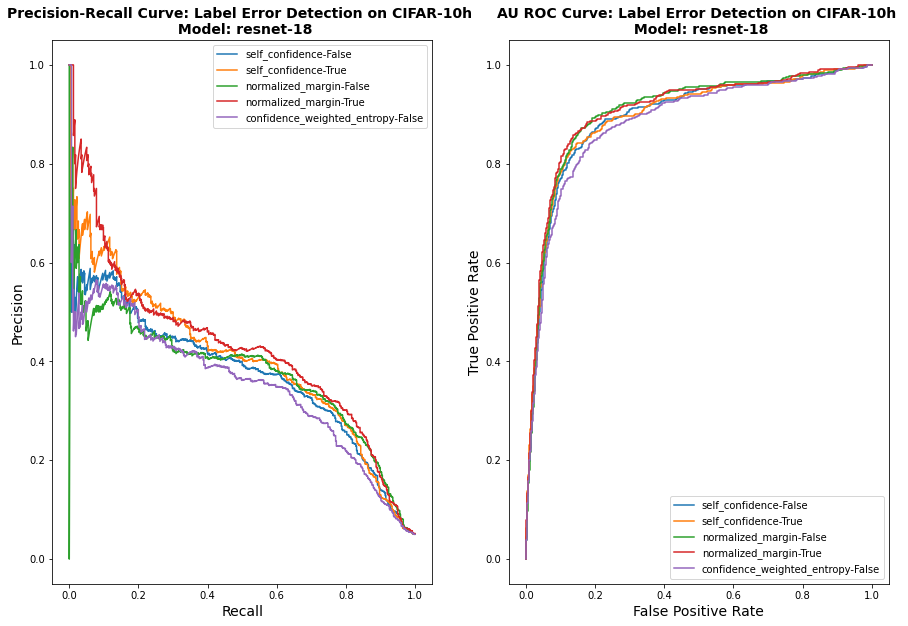

CPU times: user 1.39 s, sys: 64.5 ms, total: 1.46 s
Wall time: 1.24 s


In [38]:
%%time
plt.rcParams["figure.figsize"] = (15, 10)

results = []
results_list = []
precision_recall_curves  = []
for score_param in score_params:
    method, adjust_pred_probs = score_param
    # compute scores
    label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)
    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)
    # compute Lift@K evaluation metric
    lift_at_k_dict = {}
    for k in range(1000, 11000, 1000):
        lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)
    # save results
    results = {
        "dataset": "cifar10",
        "model": "resnet18",
        "noise_config": "Noise Amount: 0.2 | Sparsity: 0.4",
        "method": method,
        "adjust_pred_probs": adjust_pred_probs,
        "auroc": auroc
    }
    # add the lift at k metrics
    results.update(lift_at_k_dict)
    # save results
    results_list.append(results)
    
    # compute precision-recall curve using label quality scores
    precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)
    
    # compute au-roc curve using label quality scores
    fpr, tpr, thresholds = roc_curve(label_errors_target,  1 - label_quality_scores)
    
    precision_recall_curve_results = {
        "method": method,
        "adjust_pred_probs": adjust_pred_probs,
        "dataset": "cifar10",
        "model": "resnet18",
        "label_quality_scores": label_quality_scores,
        "precision": precision,
        "recall": recall,
        "thresholds": thresholds
    }

#     # store precision-recall curve results
#     precision_recall_curves.append(precision_recall_curve_results)
    
#     # store precision-recall curve results
#     auroc_curves.append(precision_recall_curve_results)
    
    # plot prc
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve: Label Error Detection on CIFAR-10h \n Model: resnet-18", fontsize=14, fontweight="bold")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f"{method}-{str(adjust_pred_probs)}")
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("AU ROC Curve: Label Error Detection on CIFAR-10h \n Model: resnet-18", fontsize=14, fontweight="bold")
    plt.legend()

plt.show()

# use better legend (i.e. self_confidence-True .. what is true?)
# but overall no interest in showing different scores of single labels, show multiannotator

In [39]:
# Create dataframe and export to csv

df_result = pd.DataFrame(results_list)
df_result.to_csv(f"./data/benchmark_results/label_quality_scores_evaluation.csv", index=False)
df_result

,dataset,model,noise_config,method,adjust_pred_probs,auroc,lift_at_1000,lift_at_2000,lift_at_3000,lift_at_4000,lift_at_5000,lift_at_6000,lift_at_7000,lift_at_8000,lift_at_9000,lift_at_10000
0,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,self_confidence,False,0.894945,6.754032,4.223790,2.983871,2.303427,1.891129,1.599462,1.379608,1.214718,1.097670,1.0
1,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,self_confidence,True,0.896848,6.834677,4.233871,2.983871,2.313508,1.883065,1.599462,1.376728,1.214718,1.102151,1.0
2,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,normalized_margin,False,0.905005,6.895161,4.364919,3.051075,2.343750,1.911290,1.609543,1.382488,1.222278,1.097670,1.0
3,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,normalized_margin,True,0.907119,7.096774,4.364919,3.030914,2.328629,1.899194,1.599462,1.376728,1.227319,1.102151,1.0
4,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,confidence_weighted_entropy,False,0.883981,6.512097,4.122984,2.930108,2.278226,1.875000,1.586022,1.370968,1.214718,1.095430,1.0


#### Notes
- ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability threshold
- Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
- Precision-Recall curves: imbalanced datasets (more sensitive to positive class), ROC curves: balanced datasets

#### Analyze Consensus label vs model performance

In [40]:
# check how much the consensus labels differ from
hlabels_df = pd.DataFrame(hlabels)
consensus_labels = get_consensus_labels(hlabels_df, pred_probs)

print('Probability annotators alone correctly predict labels: ', (true_labels == consensus_labels).sum() / 10000)
model_pred_labels = np.argmax(pred_probs, axis=1) # true labels == to what the model is likeley to predict
print('Probability model alone correctly predicts labels: ', (model_pred_labels == true_labels).sum() / 10000) # suggests model is x% likeley to predict with the consensus
print('Similar prediction between model preds and consensus_labels: ', (model_pred_labels == consensus_labels).sum())

Probability annotators alone correctly predict labels:  0.9923
Probability model alone correctly predicts labels:  0.9504
Similar prediction between model preds and consensus_labels:  9485


## Analyze label issues

In [92]:
def get_label_issues(labels, pred_probs):
    label_issues = find_label_issues(labels=labels,
                        pred_probs=pred_probs,
                        return_indices_ranked_by='self_confidence',
                        )
    issue_consensus_labels = labels[label_issues]
    issue_images = images[label_issues]
    issue_true_labels = true_labels[label_issues]
    issue_is_issue = (issue_consensus_labels != issue_true_labels) + 0
    issue_real_image_paths = [path + '/' + '/'.join(image.split('/')[-5:]) for image in issue_images]

    print('Number of label issues detected: ', len(label_issues))
    print('Number of true label issues: ', true_labels.shape[0] - np.sum(labels == true_labels))
    print('Number of true label issues detected: ', np.sum(issue_is_issue))
    
    issues_df = pd.DataFrame(zip(issue_consensus_labels, issue_true_labels, issue_is_issue, issue_real_image_paths),
            columns = ['label','true_label','is_issue','image_png'])
    return issues_df

def visualize_label_issues(issues_df, classes, scale=100):
    print('Visualizing', len(issues_df), 'issues\n')
    
    listOfImageNames = issues_df['image_png'].values

    for index, row in issues_df.iterrows():
        print('Correctly identified: ', bool(row['is_issue']), '\nGiven label: ', classes[row['label']], '\nTrue label: ', classes[row['true_label']],)
        image = Image(filename=row['image_png'])
        display(Image(filename=row['image_png'], width=scale))

classes = {0:"airplane", 
           1:"automobile", 
           2:"bird", 
           3:"cat", 
           4:"deer",
           5:"dog", 
           6:"frog", 
           7:"horse", 
           8:"ship", 
           9:"truck"}

#### Run find_label_issues on the consensus labels and visualize label issues.

In [42]:
# check how much the consensus labels differ from
hlabels_df = pd.DataFrame(hlabels)
consensus_labels = get_consensus_labels(hlabels_df, pred_probs)
issues_df = get_label_issues(hlabels, pred_probs)
issues_df.head()

Number of label issues detected:  80
Number of true label issues:  77
Number of true label issues detected:  15


,label,true_label,is_issue,image_png
0,3,3,0,/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks/data/cifar10/test/cat/test_batch_index_7099.png
1,2,4,1,/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks/data/cifar10/test/deer/test_batch_index_6197.png
2,9,9,0,/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks/data/cifar10/test/truck/test_batch_index_2495.png
3,6,2,1,/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks/data/cifar10/test/bird/test_batch_index_8982.png
4,8,8,0,/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks/data/cifar10/test/ship/test_batch_index_1685.png


Visualizing 15 issues

Correctly identified:  True 
Given label:  bird 
True label:  deer


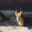

Correctly identified:  True 
Given label:  frog 
True label:  bird


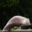

Correctly identified:  True 
Given label:  horse 
True label:  deer


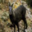

Correctly identified:  True 
Given label:  deer 
True label:  frog


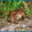

Correctly identified:  True 
Given label:  bird 
True label:  cat


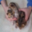

Correctly identified:  True 
Given label:  horse 
True label:  deer


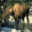

Correctly identified:  True 
Given label:  bird 
True label:  deer


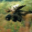

Correctly identified:  True 
Given label:  airplane 
True label:  automobile


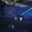

Correctly identified:  True 
Given label:  dog 
True label:  deer


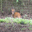

Correctly identified:  True 
Given label:  horse 
True label:  deer


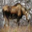

Correctly identified:  True 
Given label:  horse 
True label:  deer


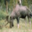

Correctly identified:  True 
Given label:  horse 
True label:  deer


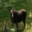

Correctly identified:  True 
Given label:  horse 
True label:  deer


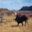

Correctly identified:  True 
Given label:  horse 
True label:  deer


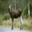

Correctly identified:  True 
Given label:  cat 
True label:  dog


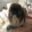

In [82]:
true_issues_df = issues_df[issues_df['is_issue'] == 1] # get a df of correctly identified true issues
# visualize_label_issues(issues_df, classes)
visualize_label_issues(true_issues_df, classes)

#### Run find_label_issues on an individual annotator's labels and visualize label issues.

In [93]:
annotator_accuracy = hlabels_error_mask.sum(axis=0) / hannotator_mask.sum(axis=0)
worst_annotator = np.argmin(annotator_accuracy)
best_annotator = np.argmax(annotator_accuracy)
print('worst annotator: ', worst_annotator, 'accuracy: ', annotator_accuracy[worst_annotator])
print('best annotator: ', best_annotator, 'accuracy: ', annotator_accuracy[best_annotator])

worst annotator:  2561 accuracy:  0.09
best annotator:  1957 accuracy:  1.0


In [96]:
annotator_id = 1 # worst = 2561, best = 1957

a_hlabels = hlabels[:,annotator_id]
a_hannotator_mask = hannotator_mask[:,annotator_id]
a_hlabels_error_mask = hlabels_error_mask[:,annotator_id]

a_labels = true_labels.copy()
a_labels[a_hannotator_mask] = a_hlabels[a_hannotator_mask]

print('Annotator accuracy: ', np.sum(a_labels[a_hannotator_mask] == true_labels[a_hannotator_mask]) / a_hannotator_mask.sum())
print('Annotator accuracy: ', annotator_accuracy[annotator_id])
print('Num correctly labeled points for annotator ', annotator_id, ': ', np.sum(a_labels == true_labels))
print('Annotator + True label accuracy: ', np.sum(a_labels == true_labels) / len(a_labels))
issues_df = get_label_issues(a_labels, pred_probs)
issues_df.head()

Annotator accuracy:  0.955
Annotator accuracy:  0.955
Num correctly labeled points for annotator  1 :  9991
Annotator + True label accuracy:  0.9991
Number of label issues detected:  82
Number of true label issues:  9
Number of true label issues detected:  6


,label,true_label,is_issue,image_png
0,3,3,0,/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks/data/cifar10/test/cat/test_batch_index_7099.png
1,9,9,0,/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks/data/cifar10/test/truck/test_batch_index_2495.png
2,8,8,0,/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks/data/cifar10/test/ship/test_batch_index_1685.png
3,7,4,1,/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks/data/cifar10/test/deer/test_batch_index_3136.png
4,3,3,0,/Users/uly/Documents/Cleanlab/h_cleanlab/multiannotator_benchmarks/data/cifar10/test/cat/test_batch_index_5458.png


## Using multiannotator library to analyze data

In [79]:
hlabels_df = pd.DataFrame(hlabels)
scores = get_label_quality_multiannotator(hlabels_df, pred_probs, return_annotator_stats=False)

/Users/uly/opt/anaconda3/envs/cleanlab-p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/uly/opt/anaconda3/envs/cleanlab-p38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/uly/opt/anaconda3/envs/cleanlab-p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/uly/opt/anaconda3/envs/cleanlab-p38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/uly/opt/anaconda3/envs/cleanlab-p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/uly/opt/anaconda3/envs/clean

Here are various overall statistics about the annotators (column names are defined in documentation):
      overall_quality  num_labeled  agreement_with_consensus  worst_class
0               0.955          200                     0.925          7.0
1               0.980          200                     0.960          2.0
2               0.955          200                     0.955          3.0
3               0.965          200                     0.945          7.0
4               0.975          200                     0.960          9.0
5               0.960          200                     0.960          3.0
6               0.965          200                     0.970          3.0
7               0.975          200                     0.930          2.0
8               0.965          200                     0.975          6.0
9               0.975          200                     0.970          2.0
10              0.970          200                     0.940          3.0
11        

In [99]:
stats.head()

,overall_quality,num_labeled,agreement_with_consensus,worst_class
0,0.955,200,0.925,7.0
1,0.980,200,0.960,2.0
2,0.955,200,0.955,3.0
3,0.965,200,0.945,7.0
4,0.975,200,0.960,9.0


In [51]:
stats = get_multiannotator_stats(hlabels_df, pred_probs, consensus_labels, 'agreement')

/Users/uly/opt/anaconda3/envs/cleanlab-p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/uly/opt/anaconda3/envs/cleanlab-p38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/uly/opt/anaconda3/envs/cleanlab-p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/uly/opt/anaconda3/envs/cleanlab-p38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/uly/opt/anaconda3/envs/cleanlab-p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/uly/opt/anaconda3/envs/clean

In [54]:
label_quality_scores = get_label_quality_scores(consensus_labels, pred_probs)

<AxesSubplot:ylabel='Frequency'>

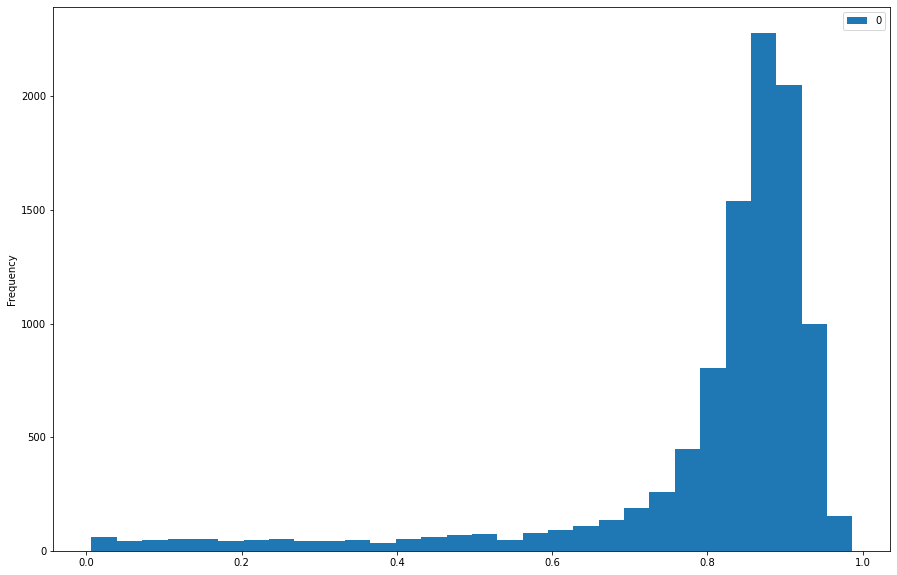

In [66]:
pd.DataFrame(label_quality_scores, columns=['']).plot.hist(bins=30,)

In [61]:
stats

,overall_quality,num_labeled,agreement_with_consensus,worst_class
0,0.955,200,0.925,7.0
1,0.980,200,0.960,2.0
2,0.955,200,0.955,3.0
3,0.965,200,0.945,7.0
4,0.975,200,0.960,9.0
5,0.960,200,0.960,3.0
6,0.965,200,0.970,3.0
7,0.975,200,0.930,2.0
8,0.965,200,0.975,6.0
9,0.975,200,0.970,2.0


<AxesSubplot:ylabel='Frequency'>

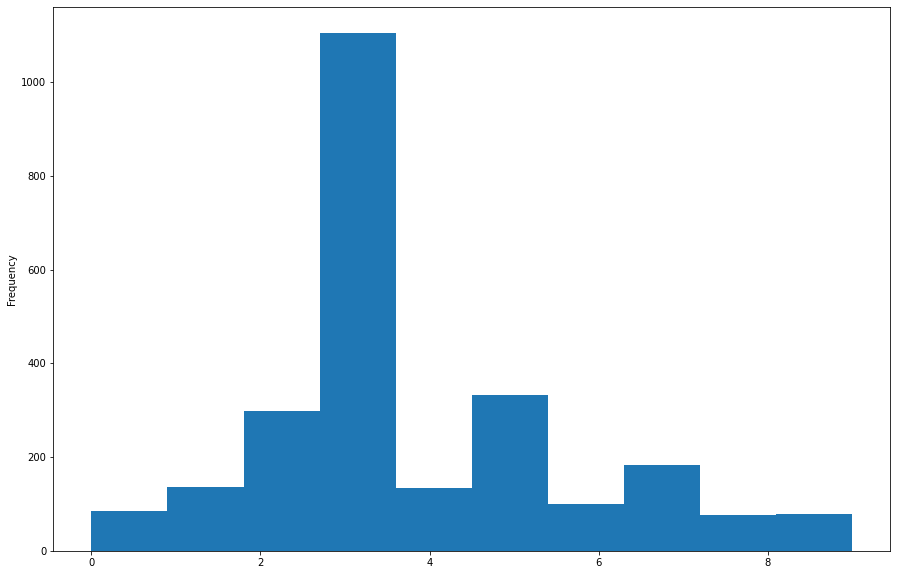

In [64]:
stats['worst_class'].plot.hist(bins=10,)

In [80]:
print(stats['overall_quality'].min(), stats['overall_quality'].max())

0.09000000000000001 1.0
